# Do the classifiers generalize to different datasets?


In [1]:
import os

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import seaborn as sns
from sklearn.calibration import CalibrationDisplay
from tqdm.notebook import tqdm

from lllm.classification_utils import Classifier, create_datasets

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# enable automatic reload in the notebook
%load_ext autoreload

In [2]:
rng = np.random.RandomState(42)

Load datasets

In [3]:
from lllm.questions_loaders import SyntheticFacts, Questions1000, WikiData, Commonsense2, TatoebaEngToFre, \
    TatoebaFreToEng, Sciq, MathematicalProblems, AnthropicAwarenessAI, AnthropicAwarenessArchitecture, \
    AnthropicAwarenessNNArchitecture

# all datasets
datasets = [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(), TatoebaEngToFre(),
            Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
            AnthropicAwarenessNNArchitecture()]
dataset_names = [dataset.__class__.__name__ for dataset in datasets]

In [4]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(datasets)

11

In [5]:
def create_test_dataset(transcripts_true, transcripts_lie, rng=None):
    assert isinstance(transcripts_true, type(transcripts_lie))
    if rng is None:
        rng = np.random.RandomState()
    # create the dataset
    if isinstance(transcripts_true, pd.Series):
        X = pd.concat([transcripts_true, transcripts_lie], ignore_index=True)
    else:
        # concatenate along the index dimension
        X = pd.concat([transcripts_true, transcripts_lie], axis=0)
    y = pd.Series([1] * len(transcripts_true) + [0] * len(transcripts_lie))
    # shuffle; this is not strictly necessary here but whatever
    indeces = rng.permutation(np.arange(len(X)))
    X, y = X.iloc[indeces], y.iloc[indeces]
    # now convert into numpy arrays
    if isinstance(X, pd.Series):
        X = np.array(X.tolist())
    y = np.array(y.tolist())
    return X, y

In [6]:
def visualize_loo_res(train_accuracy_list, train_auc_list, test_accuracy_list, test_auc_list):
    # make a plot with the accuracy and auc for each fold

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.barplot(x=list(range(len(test_accuracy_list))), y=test_accuracy_list, ax=ax[0])
    # overlay the train accuracy on the same plot, dashing the barplot
    sns.barplot(x=list(range(len(train_accuracy_list))), y=train_accuracy_list, ax=ax[0], alpha=0.5, hatch="///")
    ax[0].set_title("Accuracy")
    # ax[0].set_ylabel("Accuracy")
    # write dataset names on the x axis; rotate them 90 degrees
    ax[0].set_xticklabels(dataset_names, rotation=90)
    sns.barplot(x=list(range(len(test_auc_list))), y=test_auc_list, ax=ax[1])
    # overlay the train accuracy on the same plot, dashing the barplot
    sns.barplot(x=list(range(len(train_auc_list))), y=train_auc_list, ax=ax[1], alpha=0.5, hatch="///")
    ax[1].set_title("AUC")
    # ax[1].set_ylabel("AUC")
    # write dataset names on the x axis; rotate them 90 degrees
    ax[1].set_xticklabels(dataset_names, rotation=90)
    ax[0].set_ylim(0, 1)
    ax[1].set_ylim(0, 1)

    return fig, ax

In [7]:
def visualize_loo_auc_res(train_auc_list, test_auc_list, title="AUC"):
    # make a plot with the accuracy and auc for each fold

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.barplot(x=list(range(len(test_auc_list))), y=test_auc_list, ax=ax)
    # overlay the train accuracy on the same plot, dashing the barplot
    sns.barplot(x=list(range(len(train_auc_list))), y=train_auc_list, ax=ax, alpha=0.5, hatch="///")
    ax.set_title(title)
    # ax[1].set_ylabel("AUC")
    # write dataset names on the x axis; rotate them 90 degrees
    ax.set_xticklabels(dataset_names, rotation=90)
    ax.set_ylim(0, 1)

    return fig, ax

In [8]:
def handle_probes_data(training_datasets, testing_datasets, rng=None, print_dataset_size=False):
    # create the logprobs lists
    train_logprobs_true = pd.concat([dataset.get_lying_logprobs_difference() for dataset in training_datasets], ignore_index=True)
    train_logprobs_lie = pd.concat([dataset.get_truthful_logprobs_difference() for dataset in training_datasets], ignore_index=True)
    test_logprobs_true = pd.concat([dataset.get_lying_logprobs_difference() for dataset in testing_datasets], ignore_index=True)
    test_logprobs_lie = pd.concat([dataset.get_truthful_logprobs_difference() for dataset in testing_datasets], ignore_index=True)
    # same for probs
    train_probs_true = pd.concat([dataset.get_lying_probs_difference() for dataset in training_datasets], ignore_index=True)
    train_probs_lie = pd.concat([dataset.get_truthful_probs_difference() for dataset in training_datasets], ignore_index=True)
    test_probs_true = pd.concat([dataset.get_lying_probs_difference() for dataset in testing_datasets], ignore_index=True)
    test_probs_lie = pd.concat([dataset.get_truthful_probs_difference() for dataset in testing_datasets], ignore_index=True)

    # put probs and logprobs in the same dataset
    df_lie_train = pd.concat([train_logprobs_lie, train_probs_lie], axis=1)
    df_true_train = pd.concat([train_logprobs_true, train_probs_true], axis=1)
    df_lie_test = pd.concat([test_logprobs_lie, test_probs_lie], axis=1)
    df_true_test = pd.concat([test_logprobs_true, test_probs_true], axis=1)

    for df in [df_lie_train, df_true_train, df_lie_test, df_true_test]:
        df.columns = ["logprobs_diff", "probs_diff"]

    # merge them and compute embeddings
    X_train, X_test_in, y_train, y_test_in = create_datasets(df_true_train, df_lie_train, rng=rng)
    X_test_out, y_test_out = create_test_dataset(df_true_test, df_lie_test, rng=rng)

    if print_dataset_size:
        print("Size of training dataset: ", X_train.shape[0])

    return X_train, X_test_in, y_train, y_test_in, X_test_out, y_test_out


def split_probs_logprobs(X):
    return np.array(X["logprobs_diff"].tolist()), np.array(X["probs_diff"].tolist())


def classification_probs_logprobs(X_train, X_test_in, y_train, y_test_in, X_test_out, y_test_out, show_calibration=False, bins=20, name=None):
    # fit classifie
    log_reg_classifier = Classifier(X_train, y_train)
    # train accuracy
    train_accuracy, train_auc, train_conf_matrix = log_reg_classifier.evaluate(X_test_in, y_test_in)
    # test accuracy
    test_accuracy, test_auc, test_conf_matrix = log_reg_classifier.evaluate(X_test_out, y_test_out)

    if show_calibration:
        y_pred_proba = log_reg_classifier.predict_proba(X_test_out)
        # plot calibration curves
        calibration_display = CalibrationDisplay.from_predictions(y_test_out, y_pred_proba, n_bins=bins, name=name, strategy="quantile")

    return train_accuracy, train_auc, train_conf_matrix, test_accuracy, test_auc, test_conf_matrix


def generalization_experiments(training_datasets, testing_datasets, rng, show_calibration=False, bins=20, name=None, check_greater_0=False, probe_indeces=None, print_dataset_sizes=False):
    # handle the data
    X_train, X_test_in, y_train, y_test_in, X_test_out, y_test_out = handle_probes_data(training_datasets, testing_datasets, rng=rng, print_dataset_size=print_dataset_sizes)
    # split the data
    X_train_logprobs, X_train_probs = split_probs_logprobs(X_train)
    X_test_in_logprobs, X_test_in_probs = split_probs_logprobs(X_test_in)
    X_test_out_logprobs, X_test_out_probs = split_probs_logprobs(X_test_out)
    if check_greater_0:
        X_train_logprobs = X_train_logprobs>0
        X_test_in_logprobs = X_test_in_logprobs>0
        X_test_out_logprobs = X_test_out_logprobs>0

    if probe_indeces is not None:
        # only keep the no_lie_indices columns
        X_train_logprobs = X_train_logprobs[:, probe_indeces]
        X_test_in_logprobs = X_test_in_logprobs[:, probe_indeces]
        X_test_out_logprobs = X_test_out_logprobs[:, probe_indeces]
        # only keep the no_lie_indices columns
        X_train_probs = X_train_probs[:, probe_indeces]
        X_test_in_probs = X_test_in_probs[:, probe_indeces]
        X_test_out_probs = X_test_out_probs[:, probe_indeces]

    # classification on logprobs (or on the sign of logprobs)
    train_accuracy_logprobs, train_auc_logprobs, train_conf_matrix_logprobs, test_accuracy_logprobs, test_auc_logprobs, test_conf_matrix_logprobs = classification_probs_logprobs(X_train_logprobs, X_test_in_logprobs, y_train, y_test_in, X_test_out_logprobs, y_test_out, show_calibration=show_calibration, bins=bins, name=name)
    return_args = [train_accuracy_logprobs, train_auc_logprobs, train_conf_matrix_logprobs, test_accuracy_logprobs, test_auc_logprobs, test_conf_matrix_logprobs]
    # REMOVED THE RESULTS WITH PROBS
    # if not check_greater_0:
        # classification on probs
        # train_accuracy_probs, train_auc_probs, train_conf_matrix_probs, test_accuracy_probs, test_auc_probs, test_conf_matrix_probs = classification_probs_logprobs(X_train_probs, X_test_in_probs, y_train, y_test_in, X_test_out_probs, y_test_out)
        # return_args += [train_accuracy_probs, train_auc_probs, train_conf_matrix_probs, test_accuracy_probs, test_auc_probs, test_conf_matrix_probs]

    return return_args


In [9]:
def loo_experiments(datasets, binary, rng=None, probe_indices=None, show_calibration=False, bins=20, print_dataset_sizes=False):

    if not rng:
        rng = np.random.RandomState(42)

    train_accuracy_list_logprobs = []; train_auc_list_logprobs = []; train_conf_matrix_list_logprobs = []
    test_accuracy_list_logprobs = []; test_auc_list_logprobs = []; test_conf_matrix_list_logprobs = []
    # train_accuracy_list_probs = []; train_auc_list_probs = []; train_conf_matrix_list_probs = []
    # test_accuracy_list_probs = []; test_auc_list_probs = []; test_conf_matrix_list_probs = []

    for i, (train_indeces, test_indeces) in enumerate(loo.split(datasets)):

        # get the training and testing datasets
        training_datasets = [datasets[i] for i in train_indeces]
        testing_datasets = [datasets[i] for i in test_indeces]

        # run the experiments
        train_accuracy_logprobs, train_auc_logprobs, train_conf_matrix_logprobs, test_accuracy_logprobs, test_auc_logprobs, test_conf_matrix_logprobs = generalization_experiments(training_datasets, testing_datasets, rng, show_calibration=show_calibration, bins=bins, name=dataset_names[i], check_greater_0=binary, probe_indeces=probe_indices, print_dataset_sizes=print_dataset_sizes)

        train_accuracy_list_logprobs.append(train_accuracy_logprobs)
        train_auc_list_logprobs.append(train_auc_logprobs)
        train_conf_matrix_list_logprobs.append(train_conf_matrix_logprobs)
        test_accuracy_list_logprobs.append(test_accuracy_logprobs)
        test_auc_list_logprobs.append(test_auc_logprobs)
        test_conf_matrix_list_logprobs.append(test_conf_matrix_logprobs)

        # train_accuracy_list_probs.append(train_accuracy_probs)
        # train_auc_list_probs.append(train_auc_probs)
        # train_conf_matrix_list_probs.append(train_conf_matrix_probs)
        # test_accuracy_list_probs.append(test_accuracy_probs)
        # test_auc_list_probs.append(test_auc_probs)
        # test_conf_matrix_list_probs.append(test_conf_matrix_probs)

    return train_accuracy_list_logprobs, train_auc_list_logprobs, train_conf_matrix_list_logprobs, test_accuracy_list_logprobs, test_auc_list_logprobs, test_conf_matrix_list_logprobs  # , train_accuracy_list_probs, train_auc_list_probs, train_conf_matrix_list_probs, test_accuracy_list_probs, test_auc_list_probs, test_conf_matrix_list_probs


In [10]:
def dataset_types_experiments(binary, rng=None, probe_indices=None, show_calibration=False, bins=20,
                              print_dataset_sizes=False):
    training_datasets_list = [[SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(),
                               Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
                               AnthropicAwarenessNNArchitecture()],
                              [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(),
                               TatoebaEngToFre(),
                               Sciq(), MathematicalProblems()],
                              [Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(), TatoebaEngToFre(),
                               Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
                               AnthropicAwarenessNNArchitecture()],
                              [AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
                               AnthropicAwarenessNNArchitecture()],
                              [TatoebaFreToEng(), TatoebaEngToFre()],
                              [TatoebaFreToEng(), TatoebaEngToFre(), AnthropicAwarenessAI(),
                               AnthropicAwarenessArchitecture(), AnthropicAwarenessNNArchitecture()]]

    testing_datasets_list = [[TatoebaFreToEng(), TatoebaEngToFre(), ],
                             [AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
                              AnthropicAwarenessNNArchitecture()],
                             [SyntheticFacts()],
                             [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(),
                              TatoebaEngToFre(),
                              Sciq(), MathematicalProblems()],
                             [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(),
                              Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
                              AnthropicAwarenessNNArchitecture()],
                             [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(),
                              Sciq(), MathematicalProblems()]]

    train_accuracy_logprobs = np.zeros(len(training_datasets_list))
    train_auc_logprobs = np.zeros(len(training_datasets_list))
    test_accuracy_logprobs = np.zeros(len(training_datasets_list))
    test_auc_logprobs = np.zeros(len(training_datasets_list))
    # train_accuracy_probs = np.zeros(len(training_datasets_list))
    # train_auc_probs = np.zeros(len(training_datasets_list))
    # test_accuracy_probs = np.zeros(len(training_datasets_list))
    # test_auc_probs = np.zeros(len(training_datasets_list))

    for i, (training_datasets, testing_datasets) in enumerate(zip(training_datasets_list, testing_datasets_list)):
        train_accuracy_logprobs[i], train_auc_logprobs[i], _, test_accuracy_logprobs[i], \
        test_auc_logprobs[i], _ = generalization_experiments(
            training_datasets, testing_datasets, rng, show_calibration=show_calibration, bins=bins,
            check_greater_0=binary,
            probe_indeces=probe_indices, print_dataset_sizes=print_dataset_sizes)

    # create a dataframe with the results
    df = pd.DataFrame({
        "Train Accuracy": train_accuracy_logprobs,
        "Train AUC": train_auc_logprobs,
        "Test Accuracy": test_accuracy_logprobs,
        "Test AUC": test_auc_logprobs,
    }, index=["Test on translation, train on others", "Test on Anthropic Awareness, train on others",
              "Test on SyntheticFacts, train on others", "Train on Anthropic Awareness, test on others",
              "Train on translation, test on others", "Train on Tatoeba + Anthropic Awareness, test on others"])

    # swap rows 3 and 4
    df = df.iloc[[0, 1, 2, 4, 3, 5]]

    return df

# Experiments

## Logprobs

In [11]:
all_indices = np.arange(65)
no_lie_indices = np.load("../../results/probes_groups/no_lie_indices.npy")
lie_indices = np.load("../../results/probes_groups/lie_indices.npy")
knowable_indices = np.load("../../results/probes_groups/knowable_indices.npy")

### Leave-one-out (loo) experiments

We iteratively keep each dataset out, test on that while training on all others

In [12]:
indeces_list = [all_indices, no_lie_indices, lie_indices, knowable_indices]
name_list = ["all_probes", "no_lie", "lie", "knowable"]
results_list = []
results_mean_list = []

for indeces, name in tqdm(zip(indeces_list, name_list)):
    train_accuracy_list_logprobs, train_auc_list_logprobs, train_conf_matrix_list_logprobs, test_accuracy_list_logprobs, test_auc_list_logprobs, test_conf_matrix_list_logprobs = loo_experiments(datasets, binary=False, rng=rng, probe_indices=indeces)

    results_list.append([train_accuracy_list_logprobs, train_auc_list_logprobs, test_accuracy_list_logprobs, test_auc_list_logprobs])
    results_mean_list.append([np.mean(train_accuracy_list_logprobs), np.mean(train_auc_list_logprobs), np.mean(test_accuracy_list_logprobs), np.mean(test_auc_list_logprobs)])
# create a dataframe with the results
average_res_df = pd.DataFrame({
    "Test in-distribution Accuracy": [res[0] for res in results_mean_list],
    "Test in-distribution AUC": [res[1] for res in results_mean_list],
    "Test out-of-distribution Accuracy": [res[2] for res in results_mean_list],
    "Test out-of-distribution AUC": [res[3] for res in results_mean_list],
}, index=name_list)
print("Results average over held-out dataset")
average_res_df

0it [00:00, ?it/s]

Results average over held-out dataset


,Test in-distribution Accuracy,Test in-distribution AUC,Test out-of-distribution Accuracy,Test out-of-distribution AUC
all_probes,0.996948,0.999793,0.993206,0.999111
no_lie,0.951910,0.986056,0.945438,0.985449
lie,0.996944,0.999973,0.993634,0.999805
knowable,0.957332,0.992421,0.941272,0.988192


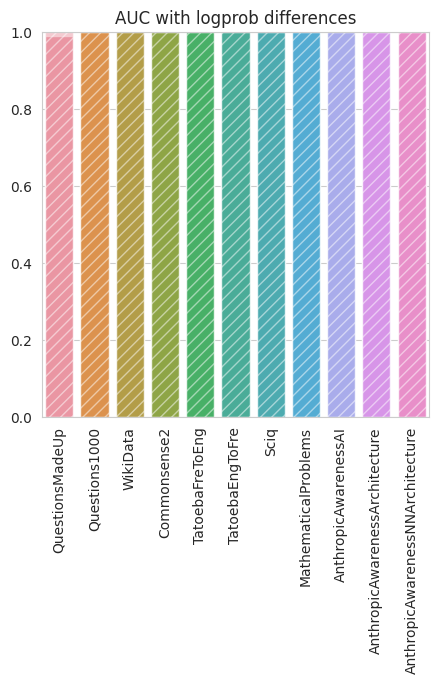

In [13]:
visualize_loo_auc_res(results_list[0][1], results_list[0][3], title="AUC with logprob differences")
plt.savefig("../../imgs/leave_one_out_dataset_all_probes_logprobs_auc.pdf")

### Experiments keeping a dataset type in/out

In [14]:
dataset_types_results = []
for indeces, name in tqdm(zip(indeces_list, name_list)):
    dataset_types_results.append(dataset_types_experiments(binary=False, rng=rng, probe_indices=indeces))
average_res_df_types = pd.DataFrame({
    "Test in-distribution Accuracy": [res["Train Accuracy"].mean() for res in dataset_types_results],
    "Test in-distribution AUC": [res["Train AUC"].mean() for res in dataset_types_results],
    "Test out-of-distribution Accuracy": [res["Test Accuracy"].mean() for res in dataset_types_results],
    "Test out-of-distribution AUC": [res["Test AUC"].mean() for res in dataset_types_results],
}, index=name_list)
print("Results average over dataset types split")
average_res_df_types

0it [00:00, ?it/s]

Results average over dataset types split


,Test in-distribution Accuracy,Test in-distribution AUC,Test out-of-distribution Accuracy,Test out-of-distribution AUC
all_probes,0.998831,0.999889,0.978467,0.997799
no_lie,0.969028,0.992094,0.912086,0.970798
lie,0.996289,0.999953,0.984340,0.997608
knowable,0.977711,0.997001,0.897963,0.970911


## Binary

In [15]:
all_indices = np.arange(65)
no_lie_indices_binary = np.load("../../results/probes_groups/no_lie_indices.npy")
lie_indices_binary = np.load("../../results/probes_groups/lie_indices.npy")
knowable_indices_binary = np.load("../../results/probes_groups/knowable_indices.npy")

### Leave-one-out (loo) experiments

We iteratively keep each dataset out, test on that while training on all others

In [16]:
indeces_list = [all_indices, no_lie_indices_binary, lie_indices_binary, knowable_indices_binary]
name_list = ["all_probes", "no_lie", "lie", "knowable"]
results_list = []
results_mean_list = []

for indeces, name in tqdm(zip(indeces_list, name_list)):
    train_accuracy_list_logprobs, train_auc_list_logprobs, train_conf_matrix_list_logprobs, test_accuracy_list_logprobs, test_auc_list_logprobs, test_conf_matrix_list_logprobs = loo_experiments(datasets, binary=True, rng=rng, probe_indices=indeces)

    results_list.append([train_accuracy_list_logprobs, train_auc_list_logprobs, test_accuracy_list_logprobs, test_auc_list_logprobs])
    results_mean_list.append([np.mean(train_accuracy_list_logprobs), np.mean(train_auc_list_logprobs), np.mean(test_accuracy_list_logprobs), np.mean(test_auc_list_logprobs)])
# create a dataframe with the results
average_res_df = pd.DataFrame({
    "Test in-distribution Accuracy": [res[0] for res in results_mean_list],
    "Test in-distribution AUC": [res[1] for res in results_mean_list],
    "Test out-of-distribution Accuracy": [res[2] for res in results_mean_list],
    "Test out-of-distribution AUC": [res[3] for res in results_mean_list],
}, index=name_list)
print("Results average over held-out dataset")
average_res_df

0it [00:00, ?it/s]

Results average over held-out dataset


,Test in-distribution Accuracy,Test in-distribution AUC,Test out-of-distribution Accuracy,Test out-of-distribution AUC
all_probes,0.991235,0.999676,0.986720,0.998320
no_lie,0.886833,0.944317,0.848187,0.949080
lie,0.981641,0.998749,0.979080,0.999015
knowable,0.948543,0.977657,0.944962,0.973343


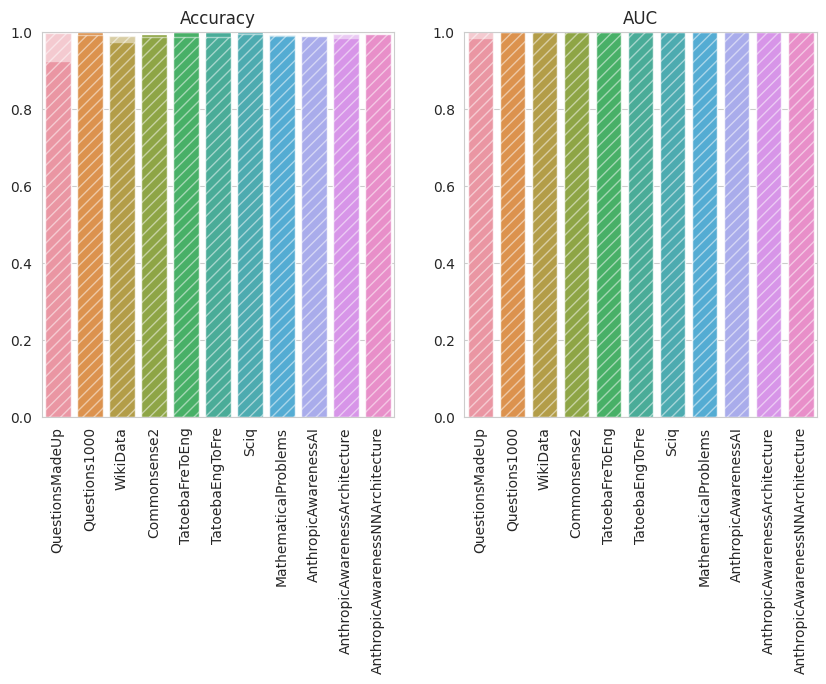

In [17]:
visualize_loo_res(*results_list[0])
plt.show()

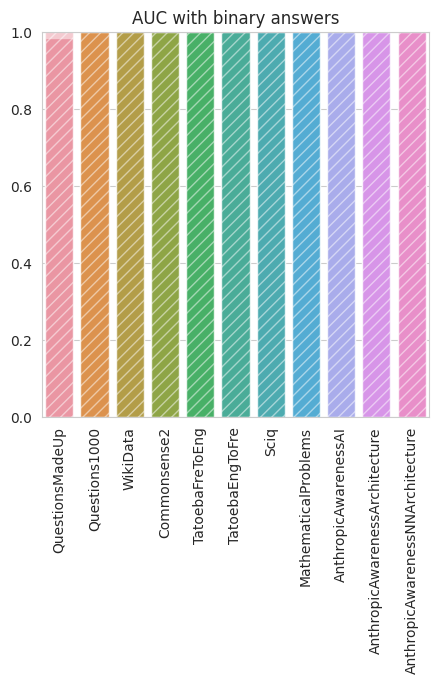

In [18]:
visualize_loo_auc_res(results_list[0][1], results_list[0][3], title="AUC with binary answers")
plt.savefig("../../imgs/leave_one_out_dataset_all_probes_binary_auc.pdf")

### Experiments keeping a dataset type in/out

In [19]:
dataset_types_results = []
for indeces, name in tqdm(zip(indeces_list, name_list)):
    dataset_types_results.append(dataset_types_experiments(binary=True, rng=rng, probe_indices=indeces))
average_res_df_types = pd.DataFrame({
    "Test in-distribution Accuracy": [res["Train Accuracy"].mean() for res in dataset_types_results],
    "Test in-distribution AUC": [res["Train AUC"].mean() for res in dataset_types_results],
    "Test out-of-distribution Accuracy": [res["Test Accuracy"].mean() for res in dataset_types_results],
    "Test out-of-distribution AUC": [res["Test AUC"].mean() for res in dataset_types_results],
}, index=name_list)
print("Results average over dataset types split")
average_res_df_types

0it [00:00, ?it/s]

Results average over dataset types split


,Test in-distribution Accuracy,Test in-distribution AUC,Test out-of-distribution Accuracy,Test out-of-distribution AUC
all_probes,0.994305,0.999892,0.964354,0.995316
no_lie,0.923761,0.965659,0.828687,0.926076
lie,0.979805,0.999196,0.965392,0.996419
knowable,0.956586,0.985070,0.900692,0.955714
